In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os

from CLAPWrapper import CLAPWrapper
from utils.dataset import *
from utils.interventions import Intervention
from utils.activations import save_dataset_activations, clear_hooks
from utils.layerwise import save_pairwise_distances

from scipy.spatial.distance import pdist, squareform
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

from einops import rearrange
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from icecream import ic
from tqdm.autonotebook import tqdm
from IPython.display import IFrame
from wand.image import Image as WImage

In [3]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [4]:
seed_everything(42)

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

module_activation_dict = {
    # Conv blocks
    'audio_encoder.base.conv_block1': nn.Identity(),    # 0
    'audio_encoder.base.conv_block2': nn.Identity(),    # 1
    'audio_encoder.base.conv_block3': nn.Identity(),    # 2
    'audio_encoder.base.conv_block4': nn.Identity(),    # 3
    'audio_encoder.base.conv_block5': nn.Identity(),    # 4
    'audio_encoder.base.conv_block6': nn.Identity(),    # 5
    'audio_encoder.base.fc1': F.relu,                   # 6
    'audio_encoder.projection.linear1': F.gelu,         # 7
    'audio_encoder.projection.linear2': nn.Identity(),  # 8
}

module_list = list(module_activation_dict.keys())

In [6]:
weights_path = "/scratch/pratyaksh.g/clap/CLAP_weights_2022_microsoft.pth"
clap_model = CLAPWrapper(weights_path, use_cuda=True if DEVICE == "cuda" else False)

In [7]:
clap_model.clap.eval()

CLAP(
  (audio_encoder): AudioEncoder(
    (base): Cnn14(
      (spectrogram_extractor): Spectrogram(
        (stft): STFT(
          (conv_real): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
          (conv_imag): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
        )
      )
      (logmel_extractor): LogmelFilterBank()
      (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_block1): ConvBlock(
        (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_block2): ConvBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [8]:
probing_dataset = MedleySolosDBDataset(class_limit=200)
testing_dataset = MedleySolosDBDataset(class_limit=200)

In [69]:
layer_idx = 4
layer_name = module_list[layer_idx]
partition_idx = 2
cluster_idx = 129

In [70]:
activations = torch.load(f'/scratch/pratyaksh.g/{testing_dataset.path_name}/activations/{layer_name}.pt')
clusters = torch.load(f'/scratch/pratyaksh.g/{probing_dataset.path_name}/clusters/{layer_name}.pt')
n_clusters = torch.load(f'/scratch/pratyaksh.g/{probing_dataset.path_name}/clusters/{layer_name}_n.pt')

In [71]:
pdf_path = f'/scratch/pratyaksh.g/{probing_dataset.path_name}/cluster-plots/{layer_name}/partition-{partition_idx}/'

for file in os.listdir(pdf_path):
    if file.endswith(f'cluster-{cluster_idx}.pdf'):
        file_path = os.path.join(pdf_path, file)
        break

print('sftp://gnode060' + file_path)
IFrame(file_path, width=800, height=600)

sftp://gnode060/scratch/pratyaksh.g/medley-solos-db/cluster-plots/audio_encoder.base.conv_block5/partition-2/007-cluster-129.pdf


In [72]:
y_labels = []
for _, _, one_hot_target in testing_dataset:
    y_labels.append(one_hot_target.detach().cpu().numpy())

class_indices = np.argmax(y_labels, axis=1)

In [73]:
layers_to_save = module_list[layer_idx + 1:]

In [74]:
n, c, w, h = activations.shape

In [75]:
performance = pd.DataFrame(
    columns=['accuracy', 'treatment', 'layer', 'label', 'fold']
)

## Normal performance

In [76]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [77]:
dist_path = f'/scratch/pratyaksh.g/{testing_dataset.path_name}/pdist/'

In [78]:
for cur_layer_name in tqdm(layers_to_save):
    dist = squareform(np.load(dist_path + cur_layer_name + '.npy'))
    knn = KNeighborsClassifier(n_neighbors=5, metric='precomputed')

    for fold, (train, test) in enumerate(skf.split(dist, class_indices)):
        knn.fit(dist[train][:, train], class_indices[train])
        pred = knn.predict(dist[test][:, train])
        gt = class_indices[test]

        # class wise accuracy
        confusion = confusion_matrix(gt, pred)
        class_wise_acc = confusion.diagonal() / confusion.sum(axis=1)

        for label_idx, label in enumerate(testing_dataset.classes):
            performance = performance.append({
                'accuracy': class_wise_acc[label_idx],
                'treatment': 'normal',
                'layer': cur_layer_name,
                'label': label,
                'fold': fold,
            }, ignore_index=True)

  0%|          | 0/4 [00:00<?, ?it/s]

In [79]:
performance

,accuracy,treatment,layer,label,fold
0,0.850,normal,audio_encoder.base.conv_block6,clarinet,0
1,0.950,normal,audio_encoder.base.conv_block6,distorted electric guitar,0
2,0.975,normal,audio_encoder.base.conv_block6,female singer,0
3,0.975,normal,audio_encoder.base.conv_block6,flute,0
4,1.000,normal,audio_encoder.base.conv_block6,piano,0
...,...,...,...,...,...
155,0.950,normal,audio_encoder.projection.linear2,flute,4
156,1.000,normal,audio_encoder.projection.linear2,piano,4
157,0.950,normal,audio_encoder.projection.linear2,tenor saxophone,4
158,0.975,normal,audio_encoder.projection.linear2,trumpet,4


## Intervened performance

In [80]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [81]:
intervention = Intervention(clap_model, module_activation_dict)

In [82]:
intervention.clear_handles()
cluster_mask = (clusters[:, partition_idx] == cluster_idx)
cluster_mask = rearrange(cluster_mask, '(c w h) -> c w h', c=c, w=w, h=h)
intervention.set_intervention(activations, cluster_mask, layer_name, type='random')

In [83]:
alt_act_path = f'/scratch/pratyaksh.g/{testing_dataset.path_name}/intervened-activations/at-{layer_name}/'
os.makedirs(alt_act_path, exist_ok=True)
save_dataset_activations(testing_dataset, clap_model, module_activation_dict, [tuple(layers_to_save)], save_path=alt_act_path)

Iterating through Medley-solos-DB: Group 0/1 :   0%|          | 0/1600 [00:00<?, ?it/s]

Saved activations for Medley-solos-DB to /scratch/pratyaksh.g/medley-solos-db/intervened-activations/at-audio_encoder.base.conv_block5/


In [84]:
alt_dist_path = f'/scratch/pratyaksh.g/{testing_dataset.path_name}/intervened-pdist/at-{layer_name}/'
os.makedirs(alt_dist_path, exist_ok=True)
save_pairwise_distances(testing_dataset, layers_to_save, act_path=alt_act_path, pdist_path=alt_dist_path)

Computing pairwise distances:   0%|          | 0/4 [00:00<?, ?it/s]

In [85]:
for cur_layer_name in tqdm(layers_to_save):
    dist = squareform(np.load(alt_dist_path + cur_layer_name + '.npy'))
    knn = KNeighborsClassifier(n_neighbors=5, metric='precomputed')

    for fold, (train, test) in enumerate(skf.split(dist, class_indices)):
        knn.fit(dist[train][:, train], class_indices[train])
        pred = knn.predict(dist[test][:, train])
        gt = class_indices[test]

        # class wise accuracy
        confusion = confusion_matrix(gt, pred)
        class_wise_acc = confusion.diagonal() / confusion.sum(axis=1)

        for label_idx, label in enumerate(testing_dataset.classes):
            performance = performance.append({
                'accuracy': class_wise_acc[label_idx],
                'treatment': 'intervened',
                'layer': cur_layer_name,
                'label': label,
                'fold': fold,
            }, ignore_index=True)

  0%|          | 0/4 [00:00<?, ?it/s]

In [86]:
intervention.clear_handles()
clear_hooks()

In [87]:
performance

,accuracy,treatment,layer,label,fold
0,0.850,normal,audio_encoder.base.conv_block6,clarinet,0
1,0.950,normal,audio_encoder.base.conv_block6,distorted electric guitar,0
2,0.975,normal,audio_encoder.base.conv_block6,female singer,0
3,0.975,normal,audio_encoder.base.conv_block6,flute,0
4,1.000,normal,audio_encoder.base.conv_block6,piano,0
...,...,...,...,...,...
315,0.950,intervened,audio_encoder.projection.linear2,flute,4
316,1.000,intervened,audio_encoder.projection.linear2,piano,4
317,0.950,intervened,audio_encoder.projection.linear2,tenor saxophone,4
318,0.975,intervened,audio_encoder.projection.linear2,trumpet,4


## Random intervention performance

In [88]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [89]:
num_neurons = clusters.shape[0]
num_neurons_in_cluster = cluster_mask.sum().item()
random_neurons = np.random.randint(0, num_neurons, num_neurons_in_cluster)
random_cluster_mask = torch.zeros_like(cluster_mask.flatten())
random_cluster_mask[random_neurons] = 1
random_cluster_mask = random_cluster_mask.bool()

In [90]:
intervention = Intervention(clap_model, module_activation_dict)

In [91]:
intervention.clear_handles()
random_cluster_mask = rearrange(random_cluster_mask, '(c w h) -> c w h', c=c, w=w, h=h)
intervention.set_intervention(activations, random_cluster_mask, layer_name, type='random')

In [92]:
alt_act_path = f'/scratch/pratyaksh.g/{testing_dataset.path_name}/random-activations/at-{layer_name}/'
os.makedirs(alt_act_path, exist_ok=True)
layers_to_save = module_list[layer_idx + 1:]
save_dataset_activations(testing_dataset, clap_model, module_activation_dict, [tuple(layers_to_save)], save_path=alt_act_path)

Iterating through Medley-solos-DB: Group 0/1 :   0%|          | 0/1600 [00:00<?, ?it/s]

Saved activations for Medley-solos-DB to /scratch/pratyaksh.g/medley-solos-db/random-activations/at-audio_encoder.base.conv_block5/


In [93]:
alt_dist_path = f'/scratch/pratyaksh.g/{testing_dataset.path_name}/random-pdist/at-{layer_name}/'
os.makedirs(alt_dist_path, exist_ok=True)
save_pairwise_distances(testing_dataset, layers_to_save, act_path=alt_act_path, pdist_path=alt_dist_path)

Computing pairwise distances:   0%|          | 0/4 [00:00<?, ?it/s]

In [94]:
for cur_layer_name in tqdm(layers_to_save):
    dist = squareform(np.load(alt_dist_path + cur_layer_name + '.npy'))
    knn = KNeighborsClassifier(n_neighbors=5, metric='precomputed')

    for fold, (train, test) in enumerate(skf.split(dist, class_indices)):
        knn.fit(dist[train][:, train], class_indices[train])
        pred = knn.predict(dist[test][:, train])
        gt = class_indices[test]

        # class wise accuracy
        confusion = confusion_matrix(gt, pred)
        class_wise_acc = confusion.diagonal() / confusion.sum(axis=1)
        for label_idx, label in enumerate(testing_dataset.classes):
            performance = performance.append({
                'accuracy': class_wise_acc[label_idx],
                'treatment': 'random',
                'layer': cur_layer_name,
                'label': label,
                'fold': fold,
            }, ignore_index=True)

  0%|          | 0/4 [00:00<?, ?it/s]

In [95]:
intervention.clear_handles()
clear_hooks()

In [96]:
performance

,accuracy,treatment,layer,label,fold
0,0.850,normal,audio_encoder.base.conv_block6,clarinet,0
1,0.950,normal,audio_encoder.base.conv_block6,distorted electric guitar,0
2,0.975,normal,audio_encoder.base.conv_block6,female singer,0
3,0.975,normal,audio_encoder.base.conv_block6,flute,0
4,1.000,normal,audio_encoder.base.conv_block6,piano,0
...,...,...,...,...,...
475,0.950,random,audio_encoder.projection.linear2,flute,4
476,1.000,random,audio_encoder.projection.linear2,piano,4
477,0.950,random,audio_encoder.projection.linear2,tenor saxophone,4
478,0.975,random,audio_encoder.projection.linear2,trumpet,4


## Plots

In [97]:
plot_path = f'/scratch/pratyaksh.g/{testing_dataset.path_name}/intervened-plots/{layer_name}/'
os.makedirs(plot_path, exist_ok=True)

In [98]:
performance.to_csv(plot_path + f'intervention-{layer_name}-p{partition_idx}-c{cluster_idx}-pd-{layer_name}-performance.csv', index=False)

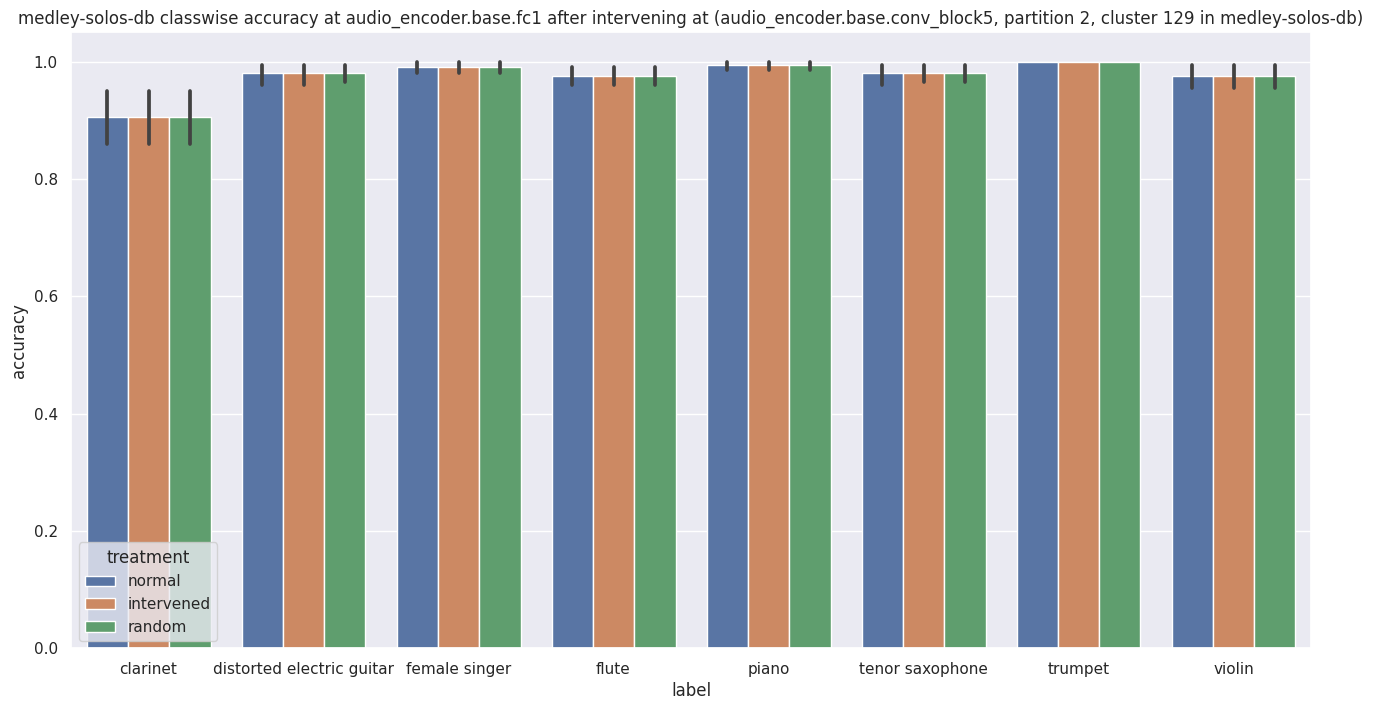

In [99]:
plt.figure(figsize=(16, 8))
sns.set_theme()
plotted_layer = 'audio_encoder.base.fc1'
sns.barplot(performance[performance['layer'] == plotted_layer], x='label', y='accuracy', hue='treatment')
plt.title(f'{testing_dataset.path_name} classwise accuracy at {plotted_layer} after intervening at ({layer_name}, partition {partition_idx}, cluster {cluster_idx} in {probing_dataset.path_name})')
plt.savefig(plot_path + f'{plotted_layer}-p{partition_idx}-c{cluster_idx}-{probing_dataset.path_name}.png')

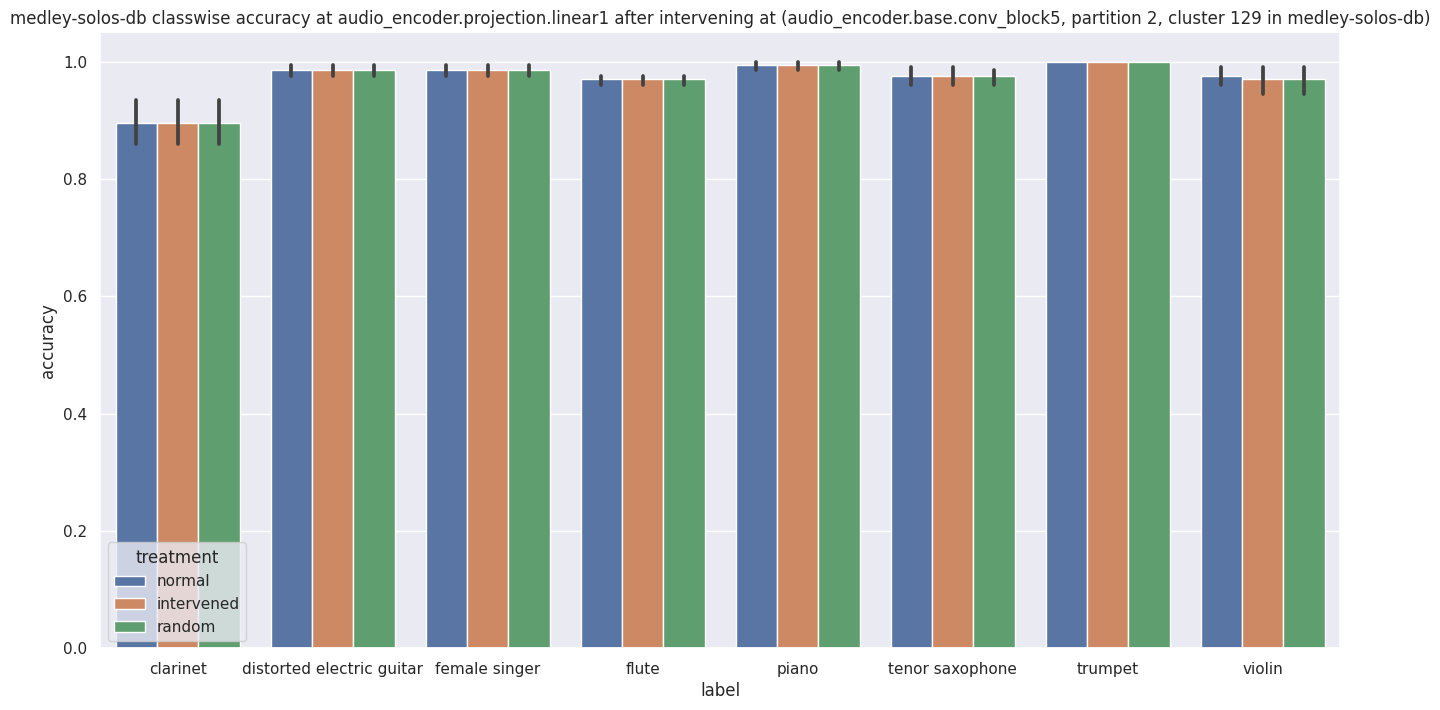

In [100]:
plt.figure(figsize=(16, 8))
sns.set_theme()
plotted_layer = 'audio_encoder.projection.linear1'
sns.barplot(performance[performance['layer'] == plotted_layer], x='label', y='accuracy', hue='treatment')
plt.title(f'{testing_dataset.path_name} classwise accuracy at {plotted_layer} after intervening at ({layer_name}, partition {partition_idx}, cluster {cluster_idx} in {probing_dataset.path_name})')
plt.savefig(plot_path + f'{plotted_layer}-p{partition_idx}-c{cluster_idx}-{probing_dataset.path_name}.png')

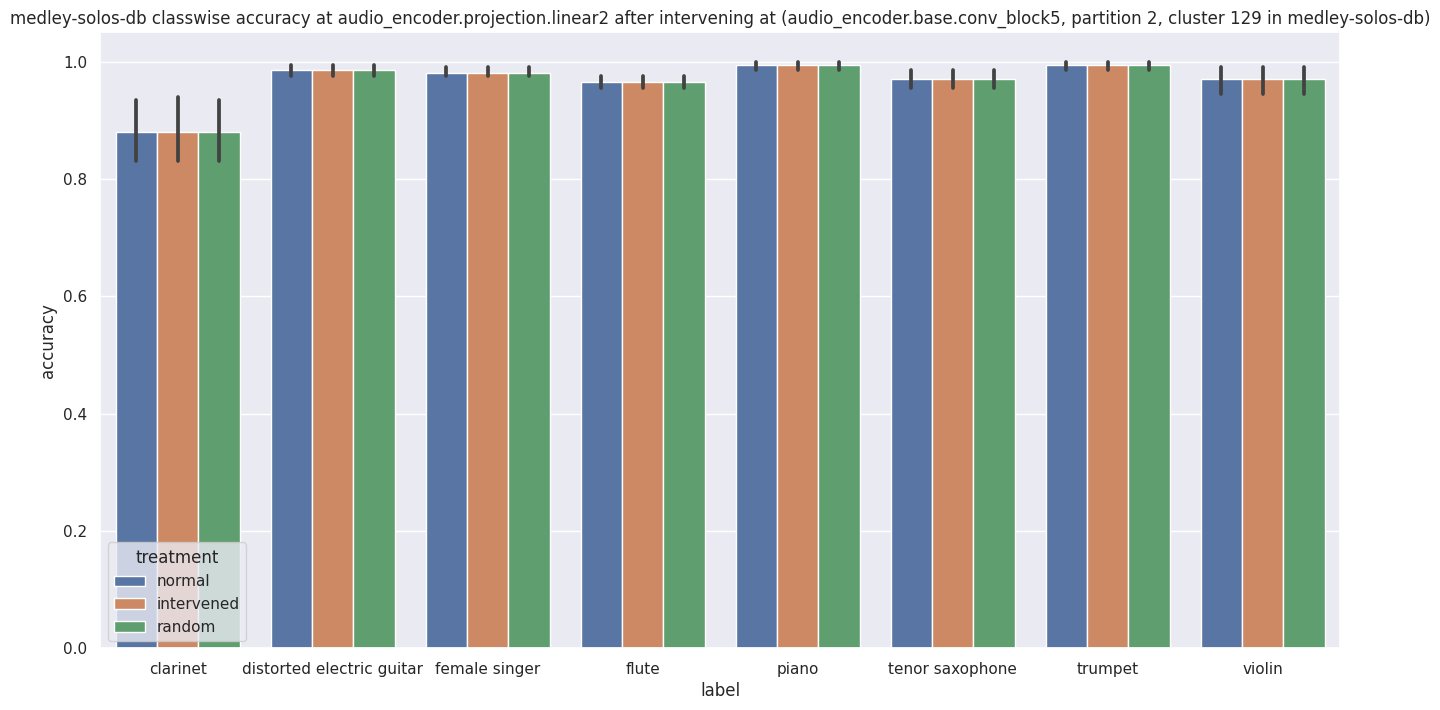

In [101]:
plt.figure(figsize=(16, 8))
sns.set_theme()
plotted_layer = 'audio_encoder.projection.linear2'
sns.barplot(performance[performance['layer'] == plotted_layer], x='label', y='accuracy', hue='treatment')
plt.title(f'{testing_dataset.path_name} classwise accuracy at {plotted_layer} after intervening at ({layer_name}, partition {partition_idx}, cluster {cluster_idx} in {probing_dataset.path_name})')
plt.savefig(plot_path + f'{plotted_layer}-p{partition_idx}-c{cluster_idx}-{probing_dataset.path_name}.png')